In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.morphology import reconstruction, remove_small_objects, remove_small_holes

In [2]:
img = cv2.imread('image/pears.png')
print(img.shape)

(485L, 729L, 3L)


In [3]:
def show_image(image, name='image'):
    cv2.imshow(name,image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

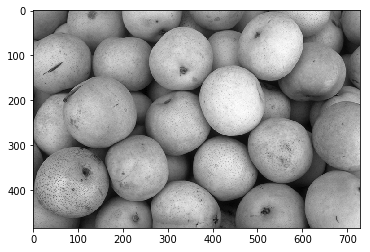

In [4]:
# Step 1: Convert image to gray scales
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')

(<matplotlib.figure.Figure at 0xbbe1e48>,
 <matplotlib.image.AxesImage at 0xdcfa5f8>)

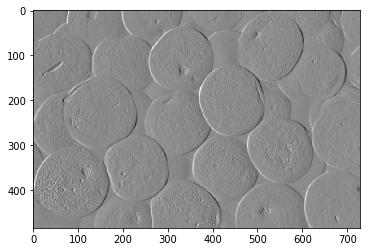

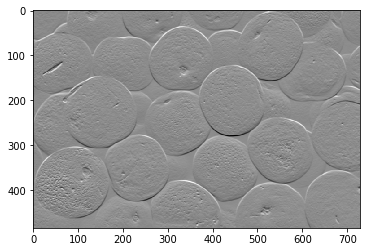

In [5]:
# Step 2: Compute Gradient Magnitude

# Use Sobel filter

# hx = np.asarray([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
# hy = np.transpose(hx)
# Ix = cv2.filter2D(gray, -1, hx)
# Iy = cv2.filter2D(gray, -1, hy)

Ix = cv2.Sobel(gray ,cv2.CV_64F,1,0,ksize=5)
Iy = cv2.Sobel(gray ,cv2.CV_64F,0,1,ksize=5)

# Show multiple images 
plt.figure(), plt.imshow(Ix, 'gray')
plt.figure(), plt.imshow(Iy, 'gray')

True

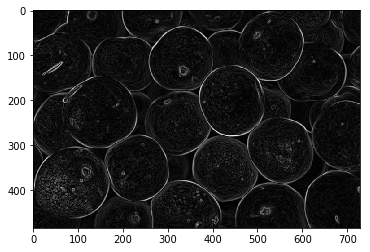

In [7]:
grad_mag = np.sqrt(Ix ** 2 + Iy ** 2, dtype=np.float64)
plt.figure(), plt.imshow(grad_mag, 'gray')
# cv2.imwrite('image/pears_gradmag.png',grad_mag)

(<matplotlib.figure.Figure at 0xde18cf8>,
 <matplotlib.image.AxesImage at 0xe5c78d0>)

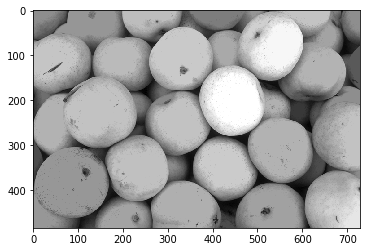

In [9]:
# Step 3: Compute foreground markers

# Opening-by-reconstruction = Erosion + Morphological reconstruction

I = gray.copy()

# Erosion
se = cv2.getStructuringElement(cv2.MORPH_ERODE, (40, 40)) # structure element
Ie = cv2.erode(I, se, iterations=1)

# Morphological reconstruction = iteratively dilation
Iobr = reconstruction(Ie, I, method='dilation')

plt.figure(), plt.imshow(Iobr, 'gray')

True

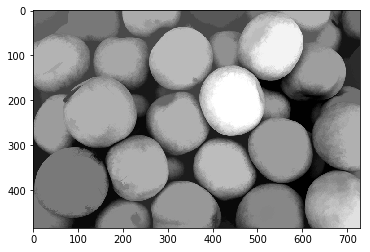

In [10]:
# Closing-by-reconstruction = Dilation + Morphological reconstruction
se = cv2.getStructuringElement(cv2.MORPH_DILATE, (40, 40)) # structure element
Iobrd = cv2.dilate(Iobr, se, iterations=1)

not_Iobrd = 255 - Iobrd # complement image
not_Iobr = 255 - Iobr

Iobrcbr = reconstruction(not_Iobrd, not_Iobr, method='dilation')
Iobrcbr = 255 - Iobrcbr

plt.figure(), plt.imshow(Iobrcbr, 'gray')
# cv2.imwrite('image/pears_openclosebrt.png', Iobrcbr)

In [11]:
def regional_maxima(image, kernel_size):
    result = np.zeros(shape=image.shape)
    radius = (kernel_size - 1) / 2
    temp = image.copy()
    temp = np.pad(temp, ((radius, radius), (radius, radius)), 'constant')
    h, w = temp.shape
    for i in np.arange(radius,h-radius,1):
        for j in np.arange(radius,w-radius,1):
            window = []
            for p in np.arange(i-radius,i+radius+1,1):
                for q in np.arange(j-radius,j+radius+1,1):
                    window.append(temp[p][q])
            max_window = max(window)
            if temp[i][j] == max_window:
                result[i-radius][j-radius] = 255
    
    return result

True

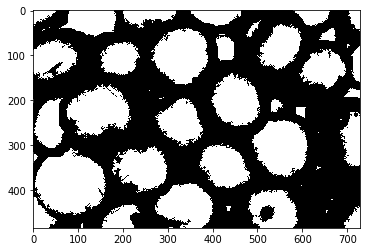

In [12]:
fgm = regional_maxima(Iobrcbr, 25)
plt.figure(), plt.imshow(fgm, 'gray')
# cv2.imwrite('image/pears_fgm.png', fgm)

(<matplotlib.figure.Figure at 0xbbee668>,
 <matplotlib.image.AxesImage at 0x10a4deb8>)

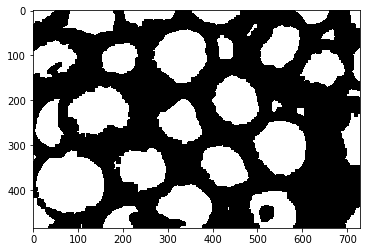

In [13]:
se2 = np.ones((5, 5), np.uint8)
fgm2 = cv2.morphologyEx(fgm, cv2.MORPH_CLOSE, se2)
fgm3 = cv2.erode(fgm2, se2, iterations=1)
plt.figure(), plt.imshow(fgm3, 'gray')

0
0.0


(<matplotlib.figure.Figure at 0xe6585c0>,
 <matplotlib.image.AxesImage at 0x10b64780>)

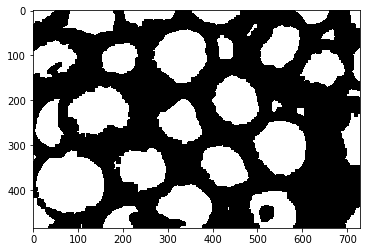

In [14]:
ret, thresh = cv2.threshold(fgm3,127,1,cv2.THRESH_BINARY)
fgm4 = remove_small_objects(np.uint8(fgm3), min_size=64, connectivity=8) # not working ...
print(np.amin(np.uint8(fgm3)))
print(np.amax(fgm4 - fgm3))

plt.figure(), plt.imshow(fgm4, 'gray')

(<matplotlib.figure.Figure at 0xe228cc0>,
 <matplotlib.image.AxesImage at 0x1165f9b0>)

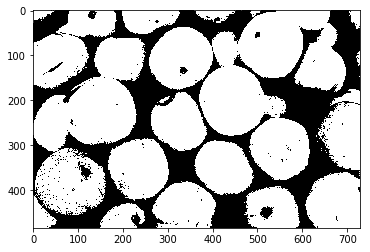

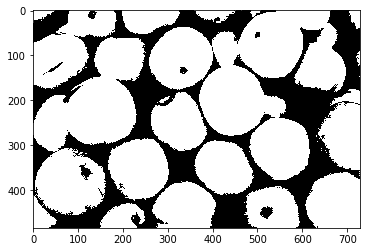

In [27]:
# Step 4: Compute Background Markers
ret, bw = cv2.threshold(gray,127,255,cv2.THRESH_OTSU)
bw2 = remove_small_holes(bw, min_size=64, connectivity=8)

plt.figure(), plt.imshow(bw, 'gray')
plt.figure(), plt.imshow(bw2, 'gray')

(<matplotlib.figure.Figure at 0xe263198>,
 <matplotlib.image.AxesImage at 0x139fab70>)

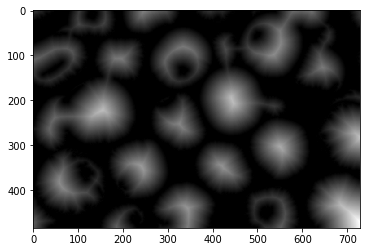

In [28]:
# Compute SKIZ

# Firstly, compute Distance Transform
# For each pixel in the image, the distance transform assigns a number that is the distance between that pixel 
# and the nearest zero pixel in image
bw2 = bw2.astype(np.uint8)
dist_transform = cv2.distanceTransform(bw2, cv2.DIST_L2, 5)

plt.figure(), plt.imshow(dist_transform, 'gray')

(<matplotlib.figure.Figure at 0x14b76390>,
 <matplotlib.image.AxesImage at 0x14e0f438>)

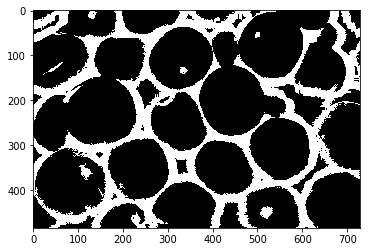

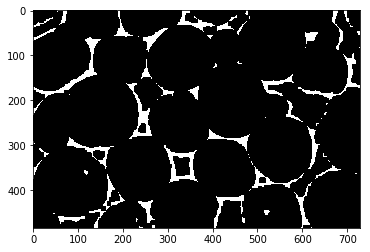

In [39]:
se = cv2.getStructuringElement(cv2.MORPH_DILATE, (40, 40)) # structure element
bw2_dilated = cv2.dilate(bw2, se, iterations=1)
bw2_border = bw2_dilated - bw2

plt.figure(), plt.imshow(bw2_border, 'gray')

se = cv2.getStructuringElement(cv2.MORPH_ERODE, (10, 10)) # structure element
bw2_border_eroded = cv2.erode(bw2_border, se, iterations=1)
bgm = bw2_border_eroded
plt.figure(), plt.imshow(bgm, 'gray')

505
254.49604743083003


(<matplotlib.figure.Figure at 0x11781588>,
 <matplotlib.image.AxesImage at 0x15ee65f8>)

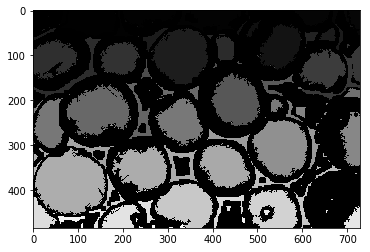

In [53]:
# Step 5: Apply watershed algorithm
from scipy.ndimage import label

fgm_bi = fgm.astype(np.bool)
bgm_bi = bgm.astype(np.bool)

lbl, ncc = label(fgm_bi | bgm_bi)
lbl = lbl * (float(255) / (ncc + 1))

print(ncc)
print(np.amax(lbl))

plt.figure(), plt.imshow(lbl, 'gray')

(<matplotlib.figure.Figure at 0x15605908>,
 <matplotlib.image.AxesImage at 0x1621c3c8>)

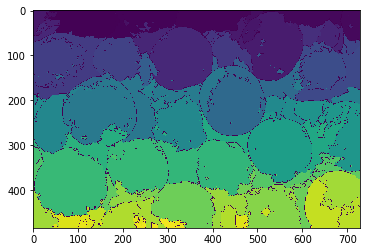

In [57]:
lbl = lbl.astype(np.int32)
cv2.watershed(img, lbl)

lbl[lbl == -1] = 0
lbl = lbl.astype(np.uint8)
result = 255 - lbl

plt.figure(), plt.imshow(result)

(<matplotlib.figure.Figure at 0x1622fcc0>,
 <matplotlib.image.AxesImage at 0x17d00898>)

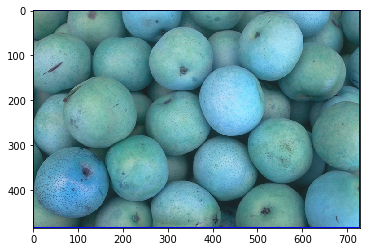

In [58]:
result[result != 255] = 0
result = cv2.dilate(result, None)
temp = img.copy()
temp[result == 255] = (0, 0, 255)

plt.figure(), plt.imshow(temp)